<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


# Real data

In [2]:
%cd ../RADOM

# restrict numpy to use only one core, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *
from models.two_species import get_Y

import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/mffang/workspace/Poisson-regression/RADOM


## Load data

In [3]:
import scanpy

adata = scanpy.read('../data/hgForebrainGlut.loom')
adata.var_names_make_unique
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [4]:
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
print(Clusters)
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
cell_colors = colors20[np.mod(clusters, 20)]

{0, 1, 2, 3, 4, 5, 6}


/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


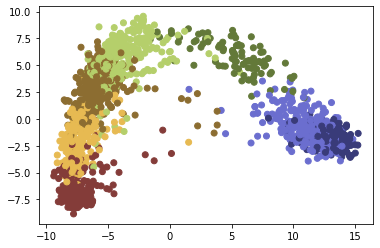

In [5]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)

pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X/total_UMI[:,None]*np.mean(total_UMI)))
plt.scatter(x[:,0],x[:,1],c=cell_colors)

**Initiate weight using clusters**

In [6]:
m=100
t_grids=np.linspace(0,1,m)
weight0 = np.ones((adata.n_obs,m))
for i in Clusters:
    idx = clusters.isin([i])
    weight0[idx,int(i*m/7):int((i+1)*m/7)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

## Inference with only marker genes

In [7]:
marker_genes=["SOX2","SLC17A7","EOMES","CLU","FBXO32",
       "UNC5D","SEZ6","RBFOX1","DCX","GRIA3",
       "STMN2", "FAM64A","ELAVL4","RNASEH2B"]
marker_idx=adata.var_names.isin(marker_genes)
gene_list=adata.var_names[marker_idx]
u=adata.layers["unspliced"][:,marker_idx].toarray()
s=adata.layers["spliced"][:,marker_idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

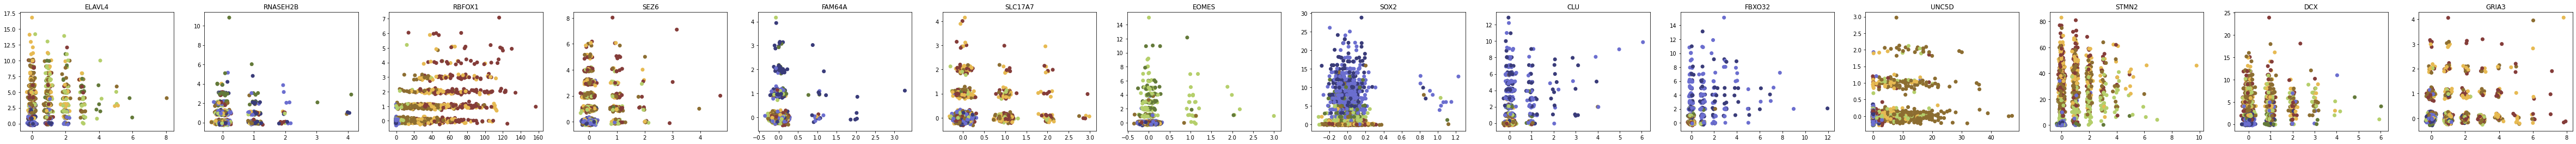

In [8]:
fig, ax = plt.subplots(1,14,figsize=(6*14,4))
for j in range(14):
    ax[j].scatter(X[:,j,0]+np.random.normal(scale=0.1,size=n),X[:,j,1]+np.random.normal(scale=0.1,size=n),c=cell_colors);
    ax[j].set_title(gene_list[j]);

### One species

In [15]:
X_one = u+s
X_one = X_one[:,:,None]
np.shape(X_one)

(1720, 14, 1)

In [13]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau, model="one_species")
Q, elbos = traj.fit(X_one, n_init=3, parallel=True, n_threads=4)

run method fit_multi_init


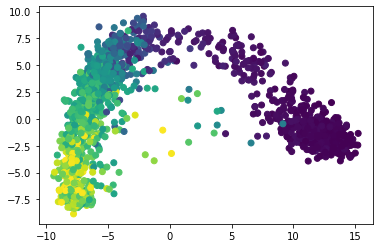

In [16]:
t_1=Q[:,0]@traj.t
plt.scatter(x[:,0],x[:,1],c=t_1);

### Two species

In [17]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau, model="two_species")
Q, elbos = traj.fit(X, n_init=3, parallel=True, n_threads=4)

run method fit_multi_init


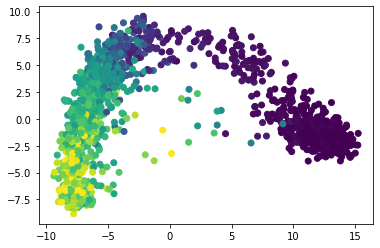

In [18]:
t_1=Q[:,0]@traj.t
plt.scatter(x[:,0],x[:,1],c=t_1);

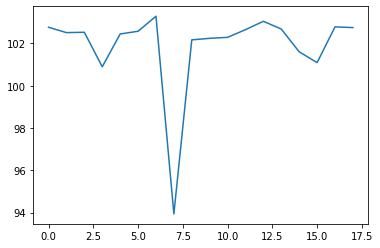

In [19]:
plt.plot(elbos)

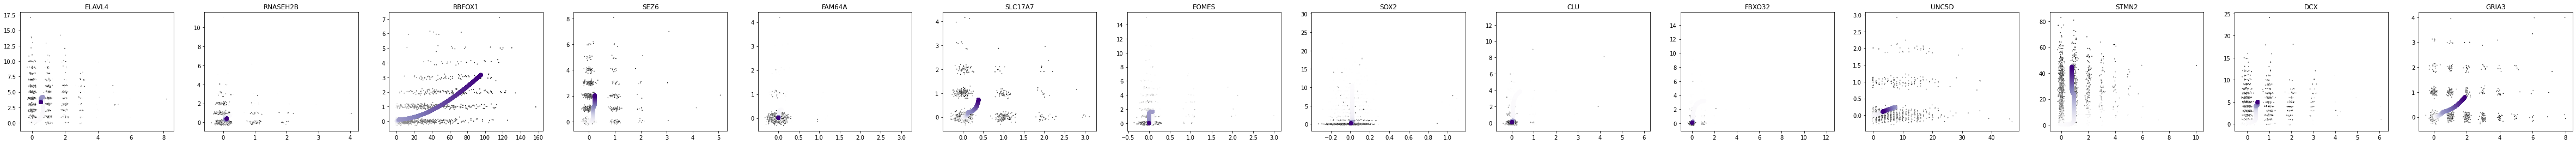

In [21]:
plot_phase(X, Q, traj, np.arange(14), gene_list)

**Check cell size** 

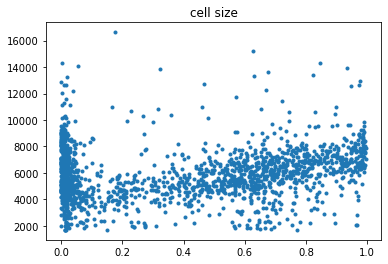

In [24]:
weight=Q[:,0]
m=np.shape(weight)[1]
h=np.linspace(0,1,m)
t_hat=np.sum(weight*h[None,:],axis=1)
plt.plot(t_hat,np.sum(adata.layers["spliced"],axis=1),'.')#,c=colors20[np.mod(clusters, 20)])
plt.title("cell size");

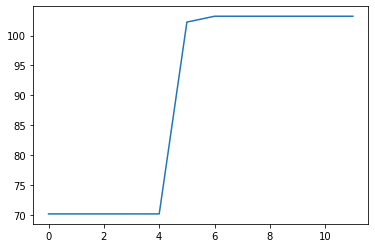

In [31]:
plt.plot(elbos)

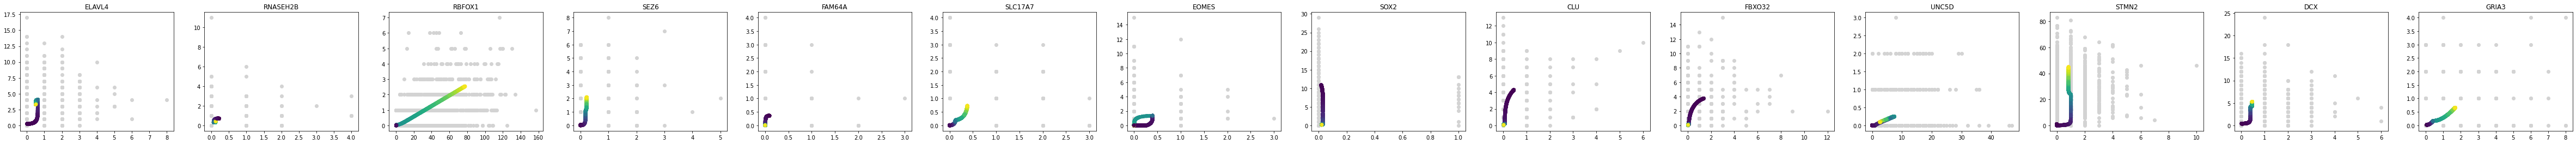

In [36]:
plot_phase(X, traj.thetas[7], Q, topo, tau, gene_list)

## Use "highly variable genes"

### Case 1

In [8]:
scanpy.pp.highly_variable_genes(adata,n_top_genes=50,flavor='seurat_v3')
idx = ( adata.var['highly_variable'] | marker_idx )
gene_list=adata.var_names[idx]
len(gene_list)

61

In [9]:
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [10]:
plot_mask = gene_list.isin(marker_genes)
gene_list[plot_mask]
plot_idx = np.arange(len(gene_list))[plot_mask]

In [11]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau)
Q, elbos = traj.fit(X, n_init=3, parallel=True, n_threads=4)

run method fit_multi_init


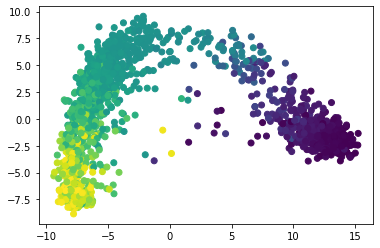

In [13]:
t_1=Q[:,0]@traj.t
plt.scatter(x[:,0],x[:,1],c=t_1);

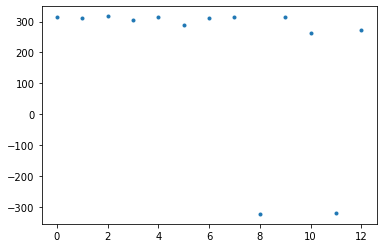

In [12]:
plt.plot(elbos,'.')

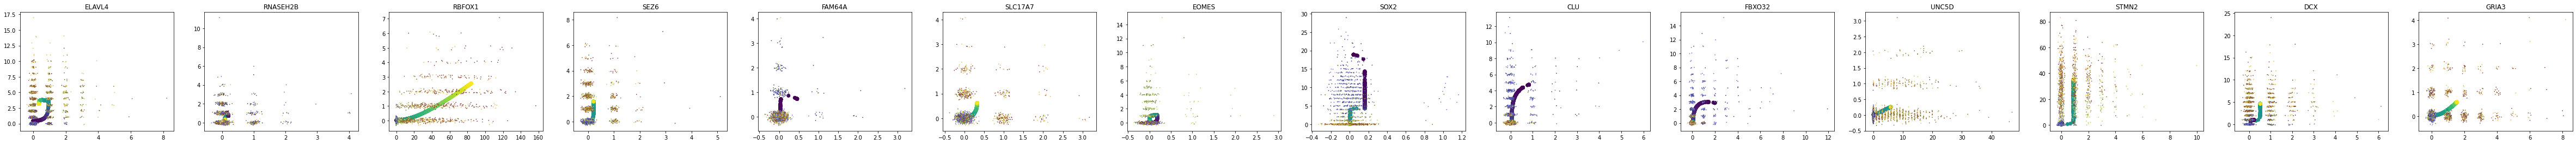

In [42]:
plot_phase(X, Q, traj, plot_idx, gene_list, cell_colors)

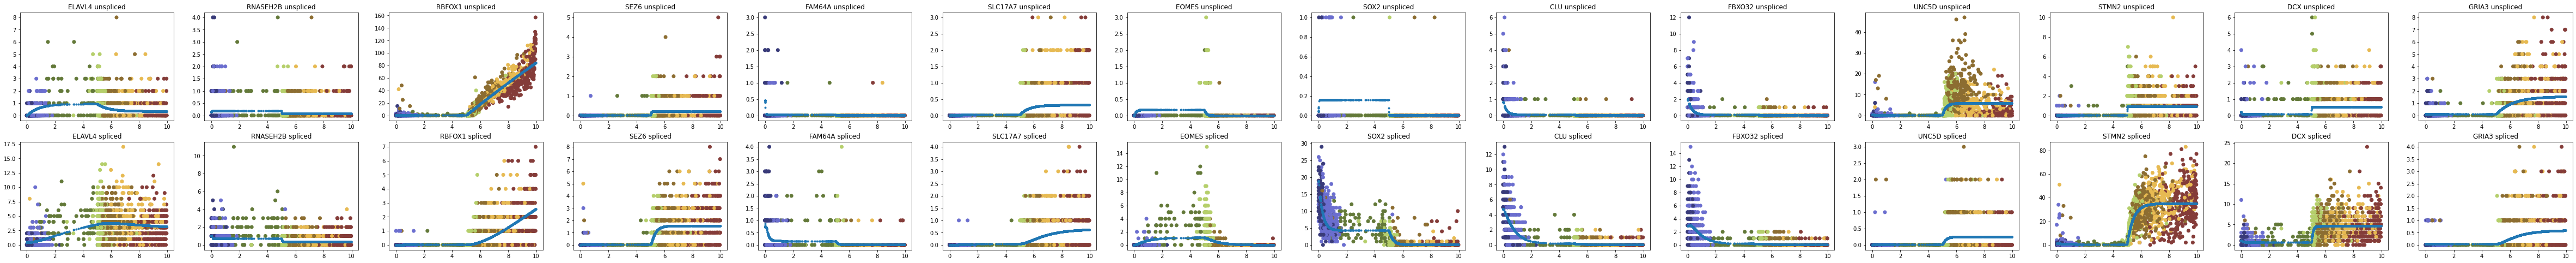

In [43]:
plot_y(X, Q, traj, plot_idx, gene_list, cell_colors)

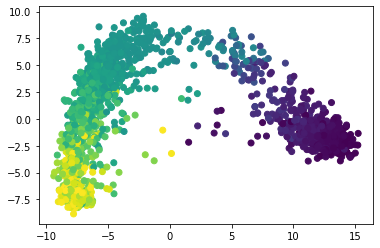

In [44]:
h=traj.t
t_1=np.sum(Q[:,0]*h[None,:],axis=1)
plt.scatter(x[:,0],x[:,1],c=t_1)

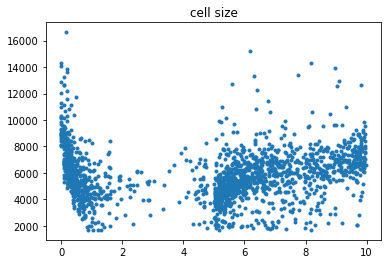

In [45]:
weight=Q[:,0]
h=traj.t
t_hat=np.sum(weight*h[None,:],axis=1)
plt.plot(t_hat,np.sum(adata.layers["spliced"],axis=1),'.')#,c=colors20[np.mod(clusters, 20)])
plt.title("cell size");

In [ ]:
accepts = []
diffs = []
mgene = np.arange(p)
mgene = mgene[plot_idx]
for j in mgene:
    nested_model = {j:[[0,1,-3],[-4,-4,-4]]}
    accept, diff = traj.compare_model(X, nested_model)

    accepts.append(accept)
    diffs.append(diff)


In [ ]:
accepts

## Case 2

In [16]:
scanpy.pp.highly_variable_genes(adata,n_top_genes=50,flavor='seurat_v3')
idx = adata.var['highly_variable']
gene_list=adata.var_names[idx]

plot_mask = gene_list.isin(marker_genes)
plot_idx = np.arange(len(gene_list))[plot_mask]

gene_list[plot_mask]

Index(['EOMES', 'SOX2', 'STMN2'], dtype='object')

In [17]:
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [18]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau)
Q, elbos = traj.fit(X, n_init=3, parallel=True, n_threads=10)

run method fit_multi_init


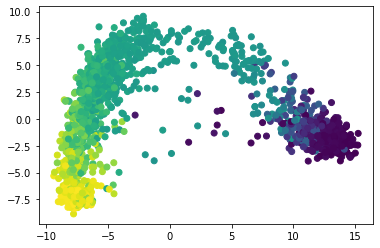

In [19]:
h=traj.t
t_1=np.sum(Q[:,0]*h[None,:],axis=1)
plt.scatter(x[:,0],x[:,1],c=t_1);

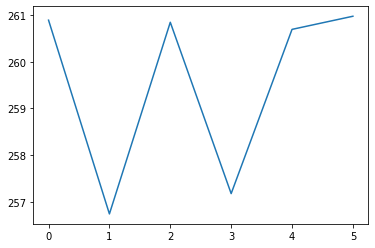

In [20]:
plt.plot(elbos)

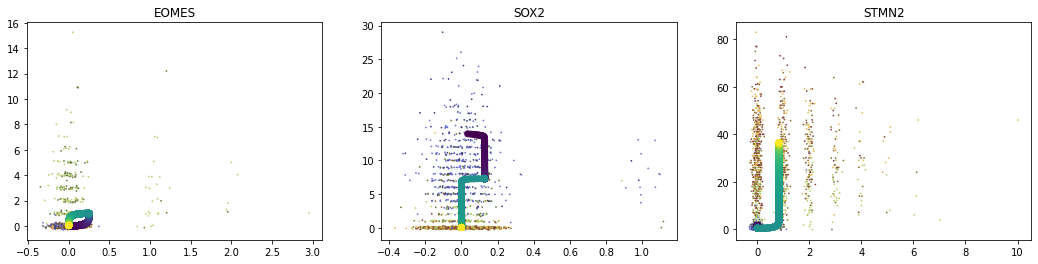

In [22]:
plot_phase(X, Q, traj, plot_idx, gene_list, cell_colors)

## Case 3

In [23]:
scanpy.pp.highly_variable_genes(adata,n_top_genes=200,flavor='seurat_v3')
idx = adata.var['highly_variable']
gene_list=adata.var_names[idx]

plot_mask = gene_list.isin(marker_genes)
plot_idx = np.arange(len(gene_list))[plot_mask]

gene_list[plot_mask]

Index(['EOMES', 'SOX2', 'CLU', 'FBXO32', 'STMN2'], dtype='object')

In [24]:
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [25]:
tau=(0,1,2)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau, verbose=1)
Q, elbos = traj.fit(X, n_init=3, parallel=True, n_threads=20)

run method fit_multi_init
trial 1


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]

trial 2



100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

trial 3



100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


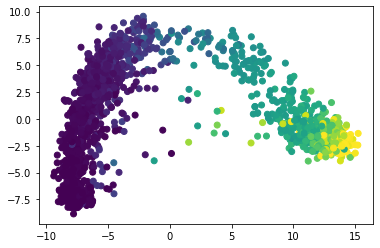

In [28]:
h=traj.t
t_1=np.sum(Q[:,0]*h[None,:],axis=1)
plt.scatter(x[:,0],x[:,1],c=t_1);

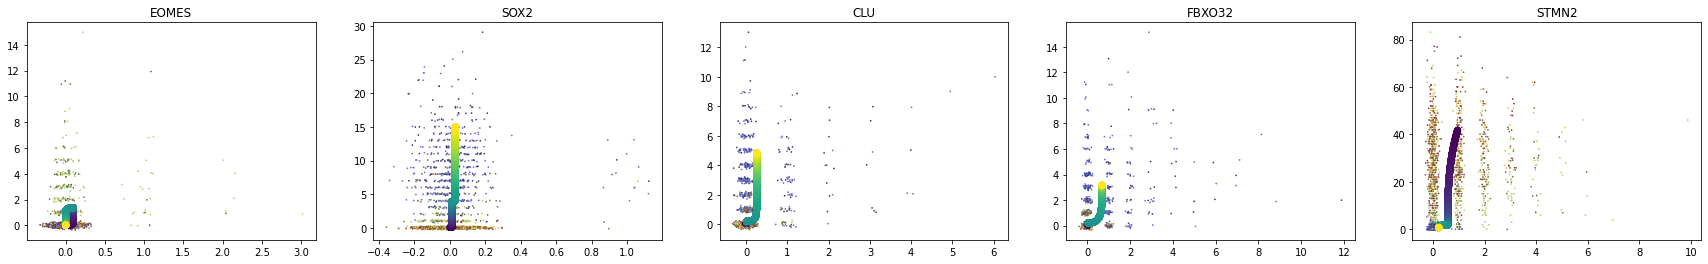

In [29]:
plot_phase(X, Q, traj, plot_idx, gene_list, cell_colors)

In [40]:
accepts = []
diffs = []
model_restrictions = {}
for j in np.arange(200):
    nested_model = {j:[[-3],[-4]]}
    accept, diff = traj.compare_model(X, nested_model)
    accepts.append(accept)
    diffs.append(diff)
    if accept:
        model_restrictions[j]=[[-3],[-4]]
accepts

[True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 F

In [44]:
traj_ = Trajectory(topo, tau, model_restrictions=model_restrictions, verbose=1)
Q_, elbos = traj_.fit(X, n_init=3, parallel=True, n_threads=20)

TypeError: __init__() got an unexpected keyword argument 'model_restrictions'

In [36]:
accepts = []
diffs = []
for j in plot_idx:
    nested_model = {j:[[0],[-4]]}
    accept, diff = traj.compare_model(X, nested_model)
    accepts.append(accept)
    diffs.append(diff)
    if accept:
        model_restrictions[j]=[[0],[-4]]   
accepts

[False, False, False, False, False]

In [37]:
accepts = []
diffs = []
for j in plot_idx:
    nested_model = {j:[[1],[0]]}
    accept, diff = traj.compare_model(X, nested_model)
    accepts.append(accept)
    diffs.append(diff)
    if accept:
        model_restrictions[j]=[[1],[0]]   
accepts

[False, False, False, False, False]